In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits

## Load all catalogs

In [2]:
def process_catalogs(path_sim_cats, catalog_paths):
    total_area = 0
    composite_cat = pd.DataFrame()  # Initialize an empty DataFrame
    
    for catalog_path in catalog_paths:
        with fits.open(os.path.join(path_sim_cats, catalog_path), memmap=False) as hdu:
            cat = pd.DataFrame(hdu[1].data).astype('<f8')[["ra", "dec", "SMIPS24", "SSPIRE250", "SSPIRE350", "SSPIRE500"]]
            
            # Update the total area
            total_area += (np.max(cat["ra"]) - np.min(cat["ra"])) * (np.max(cat["dec"]) - np.min(cat["dec"]))
            
            # Concatenate catalogs
            composite_cat = pd.concat([composite_cat, cat], ignore_index=True, copy=False)
    
    return total_area, composite_cat

In [ ]:
catalog_paths_SHARK = [f"SHARK_{i+1}_cat.fits" for i in range(15)]
catalog_paths_SIDES = [f"SIDES_{i+1}_cat.fits" for i in range(15)]

dir_sim_cats = "/mnt/g/data/PhD Projects/SR/sim_catalogs"
path_scuba_cat = "/mnt/d/SPIRE-SR-AI/data/raw/catalogs/obs/STUDIES-COSMOS_450um_v20230206.fits"
path_xid_cat = "/mnt/g/data/PhD Projects/SR/Master_Catalogue_MIPS_PACS_SPIRE_SCUBA.fits"
sr_path_cat = "/mnt/d/SPIRE-SR-AI/results/SwinUnet/SwinUnet2025May23HLR/testing/observations/cosmos_SR_catalog.fits"

In [4]:
sides_area, sides_cat = process_catalogs(dir_sim_cats, catalog_paths_SIDES)
shark_area, shark_cat = process_catalogs(dir_sim_cats, catalog_paths_SHARK)

In [7]:
xid_cat = pd.DataFrame(fits.open(path_xid_cat , memmap=False)[1].data)
xid_area = (np.max(xid_cat["RA"]) - np.min(xid_cat["RA"])) * (np.max(xid_cat["Dec"]) - np.min(xid_cat["Dec"]))

In [8]:
from astropy.table import Table

sr_cat = Table.read(sr_path_cat).to_pandas()
sr_area = 1.96

## Compute the number counts

In [9]:
# Conversion factor
deg2_to_sr = 1/3283  # squared degree to steradian
bins = 20

In [10]:
def calculate_histogram_simulations(flux_data, survey_area, max_flux):
    counts, bin_edges = np.histogram(flux_data, bins=np.logspace(-3, np.log10(max_flux), bins))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    counts_per_deg2 = (counts / survey_area) / np.diff(bin_edges)
    return bin_centers, counts_per_deg2

def get_ncounts_simulations(flux_data, survey_area, max_flux, return_err=False):
    # Calculate the histogram of flux data within the survey area
    flux_values, counts_per_sqdeg = calculate_histogram_simulations(flux_data, survey_area, max_flux)
    
    # Renormalize number counts to sr and apply the S^2.5 factor
    renormalized_counts_sr = counts_per_sqdeg * flux_values ** 2.5 * 1/deg2_to_sr

    if return_err:
        yerr = np.sqrt(counts_per_sqdeg) * flux_values ** 2.5 * 1/deg2_to_sr
        return flux_values*1e3, renormalized_counts_sr, yerr
    
    return flux_values*1e3, renormalized_counts_sr

# Conversion dictionary based on conversion options
conversion_factors = {
    0: {"multiplier": 1, "description": "Jy^1.5/sr"},  # No conversion
    1: {"multiplier": 1 / deg2_to_sr, "description": "Jy^1.5/deg^2"},
    2: lambda flux: (flux * 1e-3) ** 2.5 * (1e-3) **(-1) * (deg2_to_sr)**(-1), # dN/dS in mJy^(-1) deg^(-2)
    3: lambda flux: (flux * 1e-3) ** 2.5 / deg2_to_sr,  # dN/dS in Jy^(-1) deg^(-2)
    4: lambda flux: (flux * 1e-3) ** 2.5  # dN/dS (sr^(-1))
}

def renormalize_counts(flux, counts, err1, err2, conversion_opt=0):
    # Handle conversion option 3 separately as it depends on flux
    if conversion_opt >= 2:
        multiplier = conversion_factors[conversion_opt](flux)
    else:
        multiplier = conversion_factors[conversion_opt]["multiplier"]
    
    # Apply multiplier to counts and errors
    return flux, counts * multiplier, err1 * multiplier, err2 * multiplier
    

In [11]:
flux_sides, renormalized_counts_sides = get_ncounts_simulations(sides_cat["SSPIRE500"], sides_area, 100e-3)
flux_shark, renormalized_counts_shark = get_ncounts_simulations(shark_cat["SSPIRE500"], shark_area, 100e-3)
# flux_spritz, renormalized_counts_spritz = get_ncounts_simulations(spritz_cat["SSPIRE500"], spritz_area, 100e-3)

flux_xid, renormalized_counts_xid, err_xid = get_ncounts_simulations(xid_cat["F_500"]*1e-3, xid_area, 60e-3, return_err=True)
flux_sr, renormalized_counts_sr, err_sr = get_ncounts_simulations(sr_cat["S500SR"], sr_area, 60e-3, return_err=True)

In [12]:
err_sr

array([1.79650928e-02, 2.05712248e-01, 5.60711551e-01, 9.23083543e-01,
       1.34945049e+00, 1.92725153e+00, 2.75041470e+00, 3.95039979e+00,
       5.30865748e+00, 7.52531076e+00, 1.01281231e+01, 1.25785923e+01,
       1.79796037e+01, 1.93343399e+01, 2.07005941e+01, 2.76611750e+01,
       2.08143027e+01, 2.36545650e+01, 1.48598066e+01])

### SPIRE 500micron counts

In [13]:
# Valiante, blind, GAMA9
valiante_flux = np.array([25.4, 31.2, 38.3, 47.0, 57.8, 71.0, 87.2, 107.2])
renormalized_counts_valiante_deg2 = np.array([1.6, 1.412, 1.142, 0.626, 0.160, 0.117, 0.142, 0.009])
err_valiante_deg2 = np.array([0.043, 0.046, 0.063, 0.028, 0.035, 0.027, 0.025, 0.014])

# Bethemin, Stacking, COSMOS
bethermin_flux = np.array([2.1, 3.0, 4.2, 6.0, 8.4, 11.9, 16.8, 23.8, 33.6, 47.4, 67.0, 94.6])
renormalized_counts_bethermin = np.array([3465, 5216, 7244, 12170, 11446, 9917, 7540, 6298, 4548, 1143, 343, 202])
err_bethermin = np.array([864, 783, 1089, 1764, 1716, 2089, 2665, 675, 656, 343, 251, 230])

# Oliver, blind, COMBINED
oliver_flux = np.array([23.8, 37.5, 58.9, 85.9, 166.2, 374.1])
differential_counts_oliver = np.array([3.6e7, 1.1e7, 1.6e6, 2.3e5, 1.3e4, 1.3e3])
err_oliver1 = np.array([83, 50, 62, 56, 45, 0])*1e-2
err_oliver2 = np.array([31, 18, 25, 15, 18, 7])*1e-2
err_oliver3 = np.array([10, 6, 18, 14, 33, 50])*1e-2
err_oliver4 = np.array([5, 17, 48, 27, 20, 0])*1e-2

err_oliver = np.sqrt((err_oliver1*differential_counts_oliver)**2 + (err_oliver2*differential_counts_oliver)**2 + (err_oliver3*differential_counts_oliver)**2 + (err_oliver4*differential_counts_oliver)**2)

# clements, blind, H-ATLAS (COMBINED)
clements_flux = np.array([48, 52, 56, 60, 63, 70, 82, 95, 150, 250])
renormalized_counts_clements = np.array([1900, 1300, 1100, 760, 580, 580, 370, 190, 140, 285])
err_clements = np.array([300, 150, 200, 200, 150, 100, 100, 100, 50, 150])


valiante_flux, renormalized_counts_valiante, err_valiante, _ = renormalize_counts(
    valiante_flux, renormalized_counts_valiante_deg2, err_valiante_deg2, err_valiante_deg2, conversion_opt=1
)

oliver_flux, renormalized_counts_oliver, err_oliver, _ = renormalize_counts(
    oliver_flux, differential_counts_oliver, err_oliver,  err_oliver, conversion_opt=4
)

### JCMT SCUBA-2 450micron counts

In [14]:
S500_conversion_factor = 0.85

# Gao, blind, COSMOS
gao_flux = np.array([2.27, 2.96, 3.97, 5.38, 7.36, 10.1, 13.7, 18.4, 24.3, 31.9, 43.3])*S500_conversion_factor
renormalized_counts_gao_deg2_mjy = np.array([6010, 3269, 2065, 889, 467, 175, 109, 29.7, 9.10, 3.36, 0.57])
err_gao_deg2_mjy = np.array([1987, 396, 204, 99, 57, 28, 17, 6.4, 2.44, 1.12, 0.29])

# Zavala, blind, COSMOS
zavala_flux = np.array([6, 10, 14, 18])*S500_conversion_factor*1.056
renormalized_counts_zavala_deg2_mjy = np.array([873, 207, 76, 29])
err_zavala_deg2_mjy = np.array([100, 45, 20, 16])


# Wang2017, blind, COSMOS
wang_flux = np.array([3.94, 5.02, 6.45, 8.36, 10.9, 14.1, 17.9, 22.7, 29.0])*S500_conversion_factor*1.096
renormalized_counts_wang_deg2_mjy = np.array([1906, 814, 538, 331, 105, 61.2, 35.8, 19.6, 3.97])
err_wang_deg2_mjy = np.array([674, 209, 118, 72, 33, 21.7, 14.6, 9.8, 3.97])

# Chen2013, blind, COSMOS
chen_flux = np.array([11.23, 16.31, 22.65, 30.74, 39.69])*S500_conversion_factor*1.056
renormalized_counts_chen_deg2_mjy = np.array([55.85, 55.01, 11.55, 2.18, 0.47])
u_err_chen_deg2_mjy = np.array([52.68, 18.56, 4.55, 2.12, 1.09])
l_err_chen_deg2_mjy = np.array([52.68, 18.56, 4.55, 1.19, 0.39])

# Casey2013, blind, COSMOS
casey_flux = np.array([10.59, 14.13, 18.84, 25.12, 33.50])*S500_conversion_factor*0.941
renormalized_counts_casey_deg2_mjy = np.array([154, 129, 66.1, 6.87, 0.97])
u_err_casey_deg2_mjy = np.array([51, 31, 15, 4.13, 1.80])
l_err_casey_deg2_mjy = np.array([38, 25, 12.2, 2.58, 0.64])

# Geach2013, blind, COSMOS
geach_flux = np.array([8.0, 13.0, 18.0, 23.0])*S500_conversion_factor*1.056
renormalized_counts_geach_deg2_mjy = np.array([343.0, 88.5, 20.8, 10.4])
u_err_geach_deg2_mjy = np.array([62.6, 32.3, 16.8, 14.2])
l_err_geach_deg2_mjy = np.array([53.3, 24.2, 9.9, 6.7])

gao_flux, renormalized_counts_gao, err_gao, _ = renormalize_counts(
    gao_flux, renormalized_counts_gao_deg2_mjy, err_gao_deg2_mjy, err_gao_deg2_mjy, conversion_opt=2
)

zavala_flux, renormalized_counts_zavala, err_zavala, _ = renormalize_counts(
    zavala_flux, renormalized_counts_zavala_deg2_mjy, err_zavala_deg2_mjy, err_zavala_deg2_mjy, conversion_opt=2
)

wang_flux, renormalized_counts_wang, err_wang, _ = renormalize_counts(
    wang_flux, renormalized_counts_wang_deg2_mjy, err_wang_deg2_mjy, err_wang_deg2_mjy, conversion_opt=2
)

chen_flux, renormalized_counts_chen, err1_chen, err2_chen = renormalize_counts(
    chen_flux, renormalized_counts_chen_deg2_mjy, u_err_chen_deg2_mjy, l_err_chen_deg2_mjy, conversion_opt=2
)

casey_flux, renormalized_counts_casey, err1_casey, err2_casey = renormalize_counts(
    casey_flux, renormalized_counts_casey_deg2_mjy, u_err_casey_deg2_mjy, l_err_casey_deg2_mjy, conversion_opt=2
)

geach_flux, renormalized_counts_geach, err1_geach, err2_geach = renormalize_counts(
    geach_flux, renormalized_counts_geach_deg2_mjy, u_err_geach_deg2_mjy, l_err_geach_deg2_mjy, conversion_opt=2
)

## Plot number counts

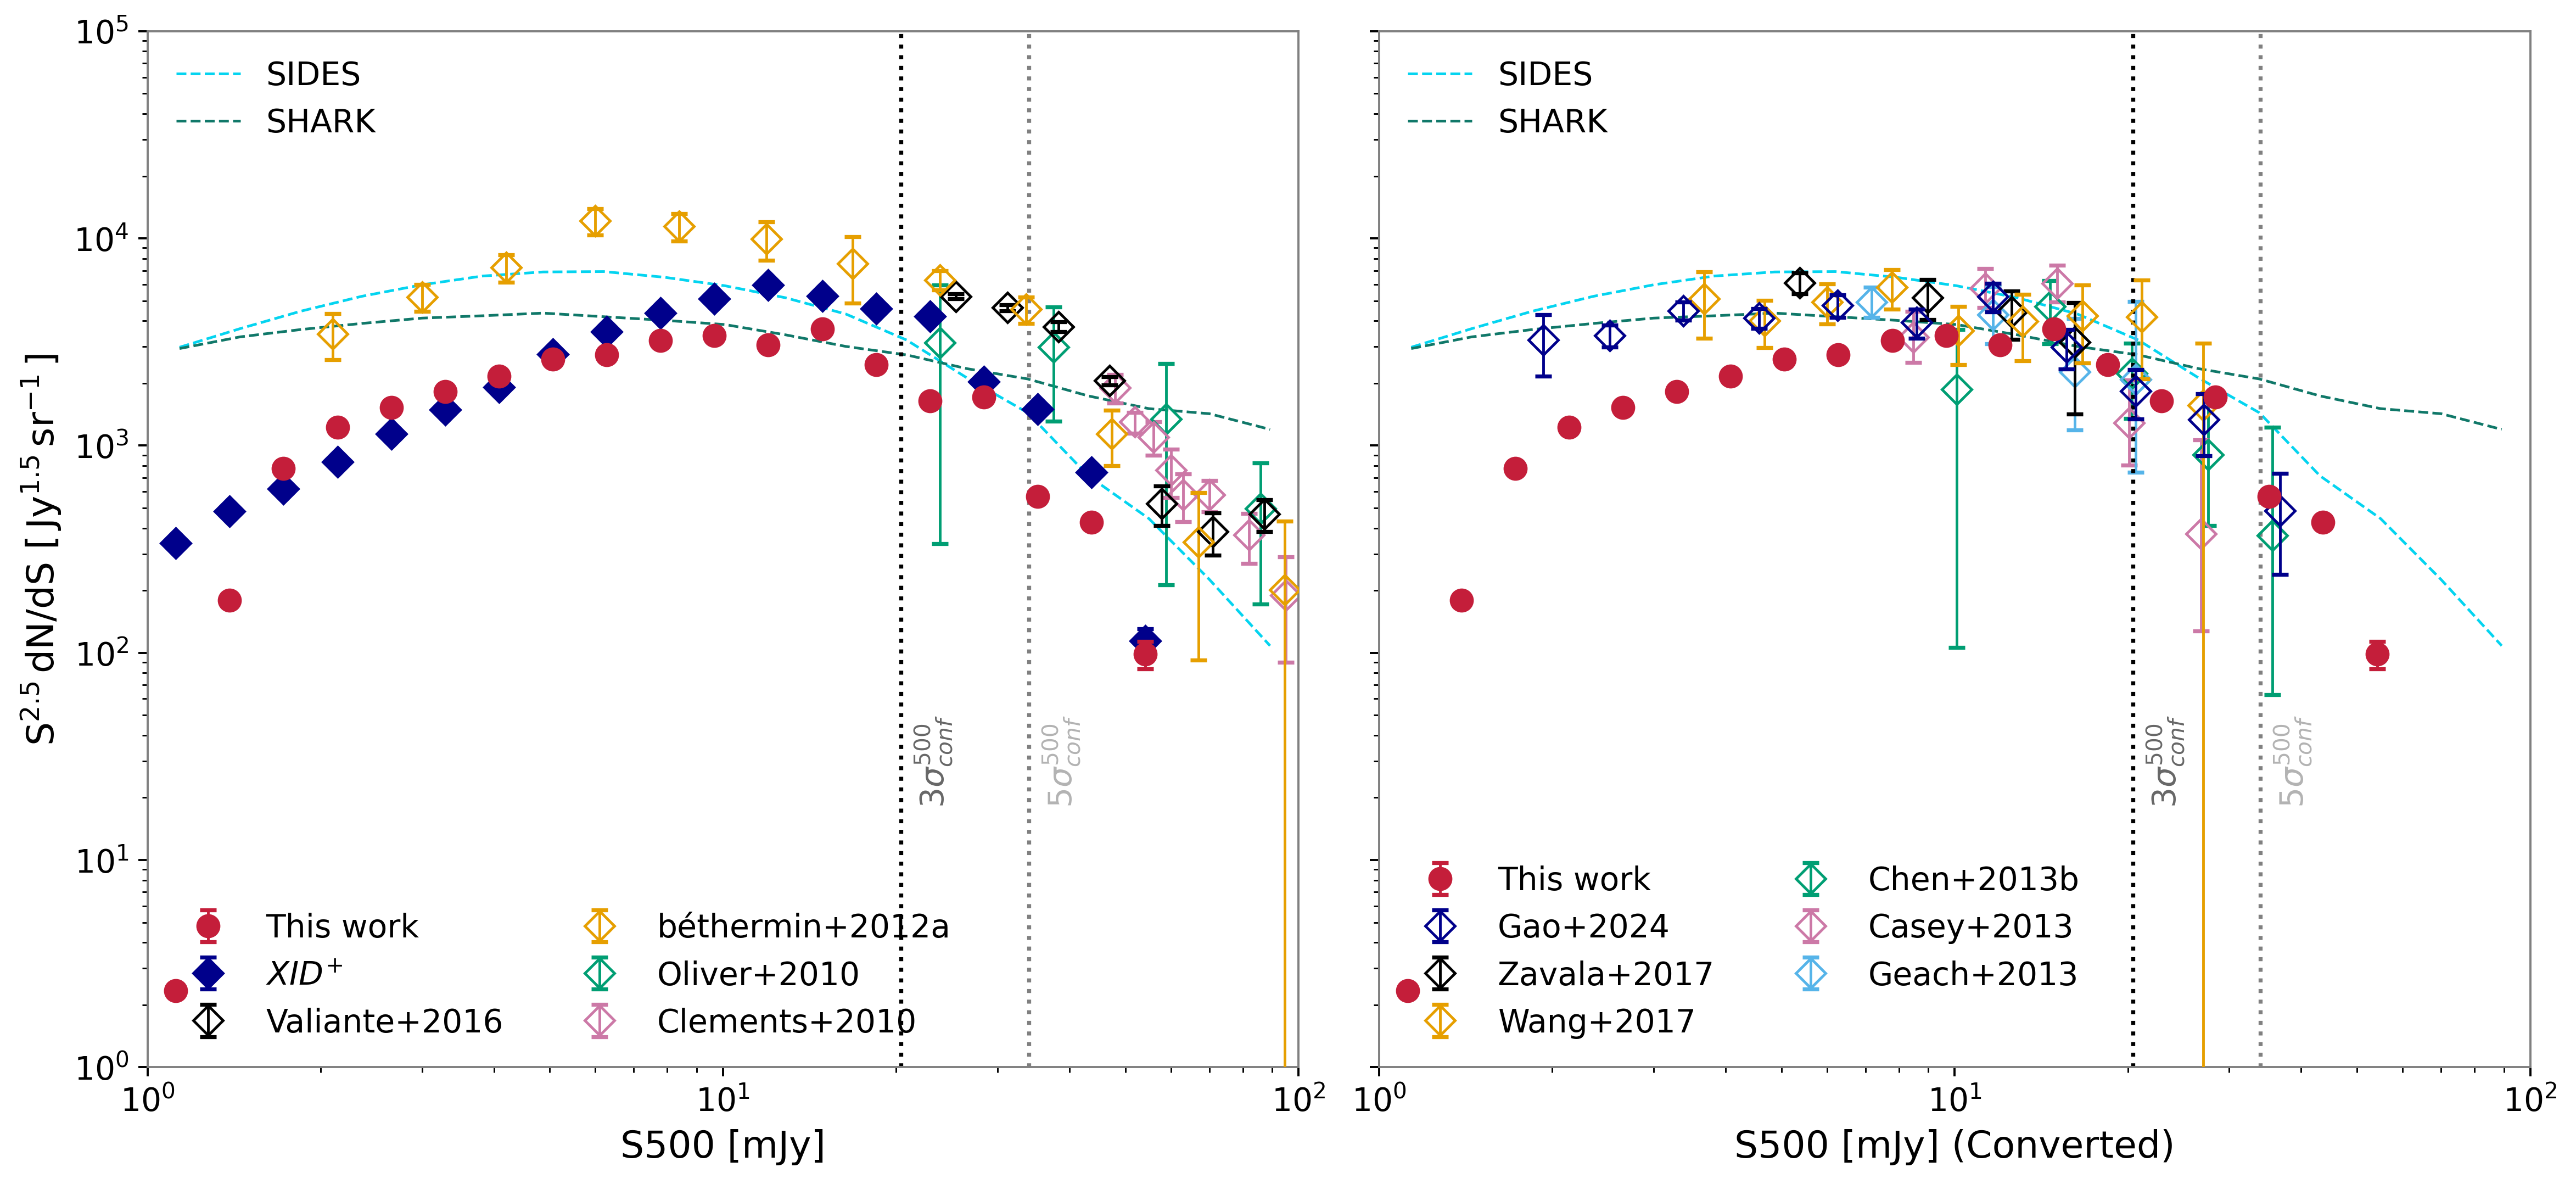

In [15]:
sim_data = [
    {"flux": flux_sides, "renormalized_counts": renormalized_counts_sides, "label": "SIDES", "color": "#04D4F0", "zorder":1},
    # {"flux": flux_spritz, "renormalized_counts": renormalized_counts_spritz, "label": "SPRITZ", "color": '#BF40BF', "zorder":1},
    {"flux": flux_shark, "renormalized_counts": renormalized_counts_shark, "label": "SHARK", "color": '#107869', "zorder":1}
]

obs_data_herschel500 = [
    {"flux": flux_sr, "renormalized_counts": renormalized_counts_sr, "u_err": err_sr, "l_err": err_sr, "label": "This work", "color": '#C41E3A', "fmt":"o", 'mfc':'#C41E3A', "zorder":5},
    {"flux": flux_xid, "renormalized_counts": renormalized_counts_xid, "u_err": err_xid, "l_err": err_xid, "label": r"$XID^{+}$", "color": '#00008B', "fmt":"D", "mfc":'#00008B', "zorder":4},
    {"flux": valiante_flux, "renormalized_counts": renormalized_counts_valiante, "u_err": err_valiante, "l_err": err_valiante, "label": "Valiante+2016", "color": '#000000', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": bethermin_flux, "renormalized_counts": renormalized_counts_bethermin, "u_err": err_bethermin, "l_err": err_bethermin, "label": "béthermin+2012a", "color": '#E69F00', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": oliver_flux, "renormalized_counts": renormalized_counts_oliver, "u_err": err_oliver, "l_err": err_oliver, "label": "Oliver+2010", "color": '#009E73', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": clements_flux, "renormalized_counts": renormalized_counts_clements, "u_err": err_clements, "l_err": err_clements, "label": "Clements+2010", "color": '#CC79A7', "fmt":"D", "mfc":'none', "zorder":2},

]

obs_data_sc450 = [
    {"flux": flux_sr, "renormalized_counts": renormalized_counts_sr, "u_err": err_sr, "l_err": err_sr, "label": "This work", "color": '#C41E3A', "fmt":"o", 'mfc':'#C41E3A', "zorder":5},
    {"flux": gao_flux, "renormalized_counts": renormalized_counts_gao, "u_err": err_gao, "l_err": err_gao, "label": "Gao+2024", "color": '#00008B', "fmt":"D", "mfc":'none', "zorder":4},
    {"flux": zavala_flux, "renormalized_counts": renormalized_counts_zavala, "u_err": err_zavala, "l_err": err_zavala, "label": "Zavala+2017", "color": '#000000', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": wang_flux, "renormalized_counts": renormalized_counts_wang, "u_err": err_wang, "l_err": err_wang, "label": "Wang+2017", "color": '#E69F00', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": chen_flux, "renormalized_counts": renormalized_counts_chen, "u_err": err1_chen, "l_err": err2_chen, "label": "Chen+2013b", "color": '#009E73', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": casey_flux, "renormalized_counts": renormalized_counts_casey, "u_err": err1_casey, "l_err": err2_casey, "label": "Casey+2013", "color": '#CC79A7', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": geach_flux, "renormalized_counts": renormalized_counts_geach, "u_err": err1_geach, "l_err": err2_geach, "label": "Geach+2013", "color": '#56B4E9', "fmt":"D", "mfc":'none', "zorder":2},

]

def number_count_plot(sim_data, obs_data, ax, xylabel, sigma_confusion):
    # Some fixed configuration settings of the plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1, 100])
    ax.set_ylim([1, 1e5])

    # First, plot the simulated data
    sim_handles = []
    for data_dict in sim_data:
        handle = ax.plot(data_dict["flux"], data_dict["renormalized_counts"], linestyle='--', color=data_dict["color"], label=data_dict["label"], lw=1, zorder=data_dict["zorder"])
        sim_handles.append(handle[0])  # Append the line handle directly

    obs_handles = []
    # Finally, plot the observational data
    for data_dict in obs_data:
        handle = ax.errorbar(data_dict["flux"], data_dict["renormalized_counts"], 
                            yerr=[data_dict["l_err"], data_dict["u_err"]],
                            fmt=data_dict["fmt"], color=data_dict["color"], label=data_dict["label"],
                            markerfacecolor=data_dict["mfc"], capsize=3, capthick=1.5, elinewidth=1, markersize=8, zorder=data_dict["zorder"])
        obs_handles.append(handle)  # This will be a tuple, keep it as is

    # Add vertical lines for 3σ and 5σ confusion levels
    ax.axvline(3 * sigma_confusion, color='black', linestyle=':', lw=1.5)
    ax.axvline(5 * sigma_confusion, color='gray', linestyle=':', lw=1.5)

    # Annotate confusion levels
    ax.text(3 * sigma_confusion * 1.05, 3e1, r'3$\sigma^{500}_{conf}$', color='black', fontsize=12, rotation=90, va='center', alpha=0.6)
    ax.text(5 * sigma_confusion * 1.05, 3e1, r'5$\sigma^{500}_{conf}$', color='gray', fontsize=12, rotation=90, va='center', alpha=0.6)

    # Labels and grid for first plot
    ax.set_xlabel(xylabel[0], fontsize=14)
    ax.set_ylabel(xylabel[1], fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    # Create legends for simulated and observational data separately
    legend1 = ax.legend(handles=sim_handles, labels=[data_dict["label"] for data_dict in sim_data], loc='upper left', fontsize=12, frameon=False)
    legend2 = ax.legend(handles=obs_handles, labels=[data_dict["label"] for data_dict in obs_data], loc='lower left', fontsize=12, frameon=False, ncol=2)

    ax.add_artist(legend1)

    # More focus on content
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['left'].set_color('gray')

sigma_confusion_herschel = 6.8
sigma_confusion_sc = 0.6

# Figure, with Y-axis shared
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True, gridspec_kw={'wspace': .07}, dpi=350)

number_count_plot(sim_data, obs_data_herschel500, ax1, xylabel=['S500 [mJy]', r'$ \text{S}^{2.5}\, \text{dN/dS} \, \, [\, \mathrm{Jy}^{1.5} \, \mathrm{sr}^{-1}\,]$'], sigma_confusion=sigma_confusion_herschel)
number_count_plot(sim_data, obs_data_sc450, ax2, xylabel=['S500 [mJy] (Converted)', ''], sigma_confusion=sigma_confusion_herschel)

# Adjust layout to make sure everything fits well
plt.savefig("number_counts.png", bbox_inches='tight')
plt.show()

